In [ ]:
!pip install wandb

In [ ]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import wandb
from wandb.integration import torch as wandb_torch
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
!gdown 1slT4AX0xKXpWo65ffatqO9tmk6htW-EK
!unrar x HW02-Practical.rar
!clear

In [ ]:
classes = ['articulated_truck', 'bus', 'car','work_van', 'background']

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

train_data = ImageFolder('HW02-Practical/Dataset/train',transform=data_transform)
test_data = ImageFolder('HW02-Practical/Dataset/test',transform=data_transform)
valid_data = ImageFolder('HW02-Practical/Dataset/valid',transform=data_transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True) 
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True) 

In [ ]:
wandb.init()#1eae3a7ad01cc326896df53e97a45bc375d91be2
config = wandb.config
config.learning_rate = 0.001

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
print('Train dataset size:', len(train_data))
print('Test dataset size:', len(test_data))
class_names = train_data.classes
print('Class names:', class_names)

Train dataset size: 15000
Test dataset size: 5000
Class names: ['articulated_truck', 'background', 'bus', 'car', 'work_van']


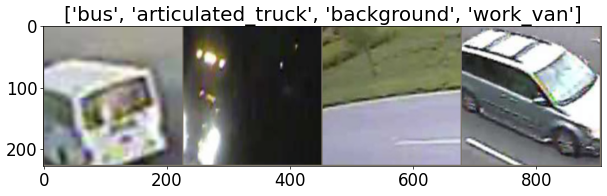

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()# load a batch of train image
iterator = iter(train_dataloader)# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Fine Tune

In [ ]:
def print_net_parameters(net):
    for name, para in net.named_parameters():
        print("-"*20)
        print(f"name: {name}")
        print("values: ")
        print(para)

In [ ]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 5)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 330MB/s]


In [ ]:
wandb.init()#1eae3a7ad01cc326896df53e97a45bc375d91be2
wandb.login()
config = dict(epochs=10,learning_rate=0.005)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
def plot_accuracy(train_accuracy,label=""):
    epochs = np.arange(1, len(train_accuracy) + 1)  # Create an array of epoch numbers
    
    # Plotting the accuracy
    plt.plot(epochs, train_accuracy, 'b', label=f'{label} Accuracy')
    #plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title(f'{label} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def train_model():
  acc_valid = []
  acc_train = []
  num_epochs = 6   #(set no of epochs)
  start_time = time.time() #(for showing time)
  for epoch in range(num_epochs): #(loop for every epoch)
      print("Epoch {} running".format(epoch)) #(printing message)
      """ Training Phase """
      model.train()    #(training model)
      running_loss = 0.   #(set loss 0)
      running_corrects = 0 
      # load a batch data of images
      for i, (inputs, labels) in enumerate(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device) 
          # forward inputs and get output
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          # get loss value and update the network weights
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(train_data)
      epoch_acc = running_corrects / len(train_data) * 100.
      acc_train.append(epoch_acc)
      print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

      model.eval()# the evaluation part
      with torch.no_grad():
          running_loss = 0.
          running_corrects = 0
          for inputs, labels in test_dataloader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          
          epoch_loss = running_loss / len(valid_data)
          epoch_acc = running_corrects / len(valid_data) * 100.
          acc_valid.append(epoch_acc)
          print('[Valid #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

  plot_accuracy(acc_train,acc_valid)

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_accuracy'
        },
    'parameters': {       
        'lr': {'max': 0.1, 'min': 0.0001}
     }
}

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='Pytorch-convolution')
wandb.agent(sweep_id, function=train_model, count=2)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 7gduvkkv
Sweep URL: https://wandb.ai/iut_/Pytorch-convolution/sweeps/7gduvkkv


wandb: Agent Starting Run: v79ttvfs with config:
wandb: 	lr: 0.0999308764903355


Epoch 0 running
[Train #0] Loss: 0.8353 Acc: 69.4067% Time: 106.3022s
[Valid #0] Loss: 0.8461 Acc: 69.6800% Time: 130.0725s
Epoch 1 running
[Train #1] Loss: 0.6323 Acc: 77.4333% Time: 227.3565s
[Valid #1] Loss: 0.6860 Acc: 74.1400% Time: 250.9462s
Epoch 2 running
[Train #2] Loss: 0.5584 Acc: 80.0667% Time: 348.9477s
[Valid #2] Loss: 0.6614 Acc: 75.5800% Time: 372.7436s
Epoch 3 running
[Train #3] Loss: 0.5058 Acc: 81.9467% Time: 470.6374s
[Valid #3] Loss: 0.6429 Acc: 76.4800% Time: 494.4849s
Epoch 4 running
[Train #4] Loss: 0.4717 Acc: 83.0000% Time: 594.4926s
[Valid #4] Loss: 0.6308 Acc: 78.3200% Time: 618.3775s
Epoch 5 running
[Train #5] Loss: 0.4642 Acc: 83.8600% Time: 715.7361s


Exception in thread Thread-17 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "<ipython-input-17-b35c31cd92fc>", line 49, in train_model
  File "<ipython-input-15-3bae2b9627ff>", line 5, in plot_accuracy
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 2812, in plot
    return gca().plot(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py", line 494, in _plot_args
    y = _check_1d(xy[1])
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py", line 1348, in _check_1d
    return np.atleast_1d(x)
  File "<__array_functi

[Valid #5] Loss: 0.5672 Acc: 79.4000% Time: 739.2436s


wandb: Agent Starting Run: yb4pl283 with config:
wandb: 	lr: 0.04488358881012621


Epoch 0 running
[Train #0] Loss: 0.4179 Acc: 85.3533% Time: 96.7503s
[Valid #0] Loss: 0.5708 Acc: 80.1000% Time: 120.4090s
Epoch 1 running
[Train #1] Loss: 0.4159 Acc: 85.2533% Time: 217.0774s
[Valid #1] Loss: 0.5661 Acc: 79.7000% Time: 240.7988s
Epoch 2 running
[Train #2] Loss: 0.3929 Acc: 86.1400% Time: 338.2481s
[Valid #2] Loss: 0.5359 Acc: 80.9200% Time: 361.6103s
Epoch 3 running
[Train #3] Loss: 0.3758 Acc: 86.6533% Time: 459.2712s
[Valid #3] Loss: 0.5230 Acc: 82.3200% Time: 482.2328s
Epoch 4 running
[Train #4] Loss: 0.3619 Acc: 87.5067% Time: 577.3245s
[Valid #4] Loss: 0.4764 Acc: 83.0200% Time: 600.5647s
Epoch 5 running


## The feature Extaction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet18(pretrained=True)   
num_features = model.fc.in_features    
model.fc = nn.Linear(num_features, 5)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 251MB/s]


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad and 'fc' not in name:
        print(name)
        param.requires_grad = False

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [ ]:
print_net_parameters(model)

--------------------
name: conv1.weight
values: 
Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ..., 

In [ ]:
def feature_train_model():
  acc_valid = []
  acc_train = []
  num_epochs = 8   #(set no of epochs)
  start_time = time.time() 
  for epoch in range(num_epochs): 
      print("Epoch {} running".format(epoch)) 
      """ Training Phase """
      model.train()    
      running_loss = 0.   #(set loss 0)
      running_corrects = 0 
      # load a batch data of images
      for i, (inputs, labels) in enumerate(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device) 
          # forward inputs 
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          # get loss value and update the network weights
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(train_data)
      epoch_acc = running_corrects / len(train_data) * 100.
      acc_train.append(epoch_acc)
      print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

      model.eval()# the evaluation part
      with torch.no_grad():
          running_loss = 0.
          running_corrects = 0
          for inputs, labels in test_dataloader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          
          epoch_loss = running_loss / len(valid_data)
          epoch_acc = running_corrects / len(valid_data) * 100.
          acc_valid.append(epoch_acc)
          print('[Valid #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

  plot_accuracy(acc_train,'Training')
  plot_accuracy(acc_valid,'Validation')

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_accuracy'
        },
    'parameters': {       
        'lr': {'max': 0.1, 'min': 0.0001}
     }
}

Create sweep with ID: 83m0esvy
Sweep URL: https://wandb.ai/iut_/Pytorch-convolution/sweeps/83m0esvy


wandb: Agent Starting Run: vpf5cw2j with config:
wandb: 	lr: 0.09252127857862412


Epoch 0 running
[Train #0] Loss: 0.7246 Acc: 72.7533% Time: 73.1963s
[Valid #0] Loss: 0.8518 Acc: 66.9000% Time: 96.9843s
Epoch 1 running
[Train #1] Loss: 0.7217 Acc: 72.9200% Time: 170.8407s
[Valid #1] Loss: 0.8396 Acc: 68.1200% Time: 193.5428s
Epoch 2 running
[Train #2] Loss: 0.7336 Acc: 72.6733% Time: 267.4697s
[Valid #2] Loss: 0.8321 Acc: 67.5200% Time: 291.3486s
Epoch 3 running
[Train #3] Loss: 0.7298 Acc: 72.4933% Time: 364.5860s
[Valid #3] Loss: 0.8393 Acc: 67.9200% Time: 388.1948s
Epoch 4 running
[Train #4] Loss: 0.7250 Acc: 72.5733% Time: 461.6393s
[Valid #4] Loss: 0.8611 Acc: 67.6200% Time: 484.5560s
Epoch 5 running
[Train #5] Loss: 0.7239 Acc: 73.1733% Time: 558.2601s
[Valid #5] Loss: 0.8529 Acc: 67.5800% Time: 581.9874s
Epoch 6 running
[Train #6] Loss: 0.7264 Acc: 73.0400% Time: 654.7970s
[Valid #6] Loss: 0.8441 Acc: 67.9400% Time: 678.6104s
Epoch 7 running
[Train #7] Loss: 0.7330 Acc: 72.3800% Time: 751.3019s


ERROR:wandb.agents.pyagent:Run vpf5cw2j errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")
wandb: ERROR Run vpf5cw2j errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")


[Valid #7] Loss: 0.8516 Acc: 67.8400% Time: 774.9817s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ak1zoup with config:
wandb: 	lr: 0.02131195052480694


Epoch 0 running
[Train #0] Loss: 0.7285 Acc: 72.7267% Time: 73.0791s
[Valid #0] Loss: 0.8401 Acc: 66.7800% Time: 96.1259s
Epoch 1 running
[Train #1] Loss: 0.7170 Acc: 73.0267% Time: 170.0093s
[Valid #1] Loss: 0.8673 Acc: 67.7200% Time: 193.4766s
Epoch 2 running
[Train #2] Loss: 0.7202 Acc: 73.1933% Time: 266.2418s
[Valid #2] Loss: 0.8177 Acc: 69.1000% Time: 289.9501s
Epoch 3 running
[Train #3] Loss: 0.7163 Acc: 73.4933% Time: 362.6277s
[Valid #3] Loss: 0.8201 Acc: 68.5000% Time: 386.5857s
Epoch 4 running
[Train #4] Loss: 0.7220 Acc: 72.8600% Time: 461.1433s
[Valid #4] Loss: 0.8733 Acc: 67.7600% Time: 484.1364s
Epoch 5 running
[Train #5] Loss: 0.7231 Acc: 72.8467% Time: 558.2251s
[Valid #5] Loss: 0.8033 Acc: 69.2000% Time: 581.6806s
Epoch 6 running
[Train #6] Loss: 0.7301 Acc: 72.4533% Time: 654.0945s
[Valid #6] Loss: 0.8895 Acc: 67.2600% Time: 677.5515s
Epoch 7 running
[Train #7] Loss: 0.7347 Acc: 72.4800% Time: 750.5333s


ERROR:wandb.agents.pyagent:Run 2ak1zoup errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")
wandb: ERROR Run 2ak1zoup errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")


[Valid #7] Loss: 0.8740 Acc: 67.2000% Time: 773.7698s


wandb: Agent Starting Run: 5p8gj8vz with config:
wandb: 	lr: 0.06575533776555285


Epoch 0 running
[Train #0] Loss: 0.7256 Acc: 72.8867% Time: 73.2366s
[Valid #0] Loss: 0.8701 Acc: 67.3800% Time: 96.4016s
Epoch 1 running
[Train #1] Loss: 0.7297 Acc: 72.6133% Time: 168.8187s
[Valid #1] Loss: 0.8218 Acc: 68.4000% Time: 192.2173s
Epoch 2 running
[Train #2] Loss: 0.7262 Acc: 72.8000% Time: 264.3964s
[Valid #2] Loss: 0.8749 Acc: 66.9800% Time: 287.8195s
Epoch 3 running
[Train #3] Loss: 0.7282 Acc: 72.6333% Time: 362.0427s
[Valid #3] Loss: 0.8167 Acc: 68.9200% Time: 384.4846s
Epoch 4 running
[Train #4] Loss: 0.7225 Acc: 72.9200% Time: 457.7770s
[Valid #4] Loss: 0.8812 Acc: 67.0800% Time: 481.3757s
Epoch 5 running
[Train #5] Loss: 0.7158 Acc: 73.1000% Time: 554.0008s
[Valid #5] Loss: 0.8794 Acc: 66.4200% Time: 577.3700s
Epoch 6 running
[Train #6] Loss: 0.7252 Acc: 73.2133% Time: 652.6950s
[Valid #6] Loss: 0.8838 Acc: 66.7400% Time: 676.3230s
Epoch 7 running
[Train #7] Loss: 0.7238 Acc: 72.7400% Time: 751.0794s


ERROR:wandb.agents.pyagent:Run 5p8gj8vz errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")
wandb: ERROR Run 5p8gj8vz errored: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")


[Valid #7] Loss: 0.8381 Acc: 68.1600% Time: 774.9084s


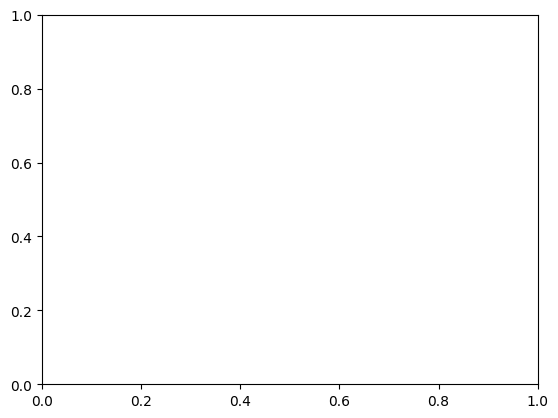

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='Pytorch-convolution')
wandb.agent(sweep_id, function=feature_train_model, count=3)